In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import seaborn as sns
from datetime import datetime
import time
import seaborn as sns

In [2]:
data=pd.read_csv("10_km_Riorges.csv")

In [3]:
data.head()

,Athlète,Ligue,Performance,Naissance,Catégorie,time_delta,time_gap,duration,Nom,Prénom
0,LORTON Guillaume,ARA,N4,1989,SEM,0 days 00:30:58,0 days 00:00:00,1858.0,LORTON,Guillaume
1,BETRON Adrien,ARA,IR1,1989,SEM,0 days 00:31:30,0 days 00:00:32,1890.0,BETRON,Adrien
2,MOULIN Loic,ARA,IR2,1992,SEM,0 days 00:32:01,0 days 00:01:03,1921.0,MOULIN,Loic
3,DEBROUCKER Guillaume,ARA,IR2,1982,M1M,0 days 00:32:15,0 days 00:01:17,1935.0,DEBROUCKER,Guillaume
4,KEMEI Charles,ARA,IR2,1984,M0M,0 days 00:32:40,0 days 00:01:42,1960.0,KEMEI,Charles


In [4]:
data['h_duration'] = data['duration'].apply(lambda x : pd.to_datetime(x,unit="s").strftime('%H:%M:%S'))
data

,Athlète,Ligue,Performance,Naissance,Catégorie,time_delta,time_gap,duration,Nom,Prénom,h_duration
0,LORTON Guillaume,ARA,N4,1989,SEM,0 days 00:30:58,0 days 00:00:00,1858.0,LORTON,Guillaume,00:30:58
1,BETRON Adrien,ARA,IR1,1989,SEM,0 days 00:31:30,0 days 00:00:32,1890.0,BETRON,Adrien,00:31:30
2,MOULIN Loic,ARA,IR2,1992,SEM,0 days 00:32:01,0 days 00:01:03,1921.0,MOULIN,Loic,00:32:01
3,DEBROUCKER Guillaume,ARA,IR2,1982,M1M,0 days 00:32:15,0 days 00:01:17,1935.0,DEBROUCKER,Guillaume,00:32:15
4,KEMEI Charles,ARA,IR2,1984,M0M,0 days 00:32:40,0 days 00:01:42,1960.0,KEMEI,Charles,00:32:40
...,...,...,...,...,...,...,...,...,...,...,...
245,BARTASSOT Jean,0,D8,1980,M1M,0 days 01:05:58,0 days 00:35:00,3958.0,BARTASSOT,Jean,01:05:58
246,SURGET Laurent,0,D8,1965,M4M,0 days 01:06:37,0 days 00:35:39,3997.0,SURGET,Laurent,01:06:37
247,GENEVOIS Magali,0,D8,1986,M0F,0 days 01:07:18,0 days 00:36:20,4038.0,GENEVOIS,Magali,01:07:18
248,CAVELIER Clementine,0,D8,1990,SEF,0 days 01:07:20,0 days 00:36:22,4040.0,CAVELIER,Clementine,01:07:20


In [5]:
data['duration'].describe()

count     250.000000
mean     2809.836000
std       505.940003
min      1858.000000
25%      2380.000000
50%      2769.500000
75%      3165.500000
max      4245.000000
Name: duration, dtype: float64

Fonction permettant à l'athlète d'acquérir des données personnels sur sa performance :

In [6]:
def info_participant(x,y):
    z=data.index[data.Athlète==(y.upper()+" "+x.capitalize())]
    print("Votre temps d'arrivée est", data.loc[z[0],'h_duration'])
    print("Votre place d'arrivée est", data.index[z[0]]+1)
    print("Votre performance est classée", data.loc[z[0],'Performance'])
    print("Vous faites partie du top", math.ceil(((data.duration<=data.loc[z[0],'duration']).sum())/len(data)*100),"%")
    print("Vous êtes classé au rang", ((data[abs(data.loc[:,'Naissance']-data.loc[z[0],'Naissance'])<=5])['duration'].rank()).loc[z[0]], "parmis les",len((data[abs(data.loc[:,'Naissance']-data.loc[z[0],'Naissance'])<=5])),"athlètes ayant plus ou moins 5 ans de différence avec vous")

Exemple d'utilisation :

In [7]:
info_participant("charles","kemei")

Votre temps d'arrivée est 00:32:40
Votre place d'arrivée est 5
Votre performance est classée IR2
Vous faites partie du top 2 %
Vous êtes classé au rang 4.0 parmis les 89 athlètes ayant plus ou moins 5 ans de différence avec vous


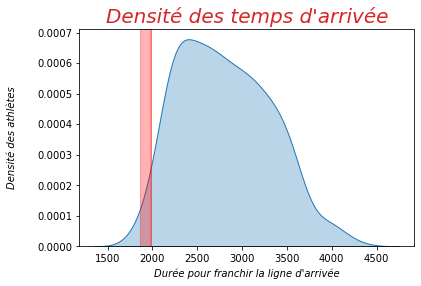

In [34]:
sns.kdeplot(data['duration'], shade=True,  alpha=.3)

# Calcule du quantile 75% quantile
x="Charles"
y="KEMEI"
z=data.index[data.Athlète==(y.upper()+" "+x.capitalize())]
quantile75 = np.quantile(data['duration'], ((data.duration<=data.loc[z[0],'duration']).sum())/len(data))

# Ajout d'une aire colorée après le quantile

plt.axvline(quantile75, color='r',alpha=0.3)
plt.axvspan(quantile75, min(data['duration']), color='r', alpha=0.3)

# Ajout des labels et titre
plt.title("Densité des temps d'arrivée", color= 'tab:red', fontsize = '20', fontstyle = 'oblique')
plt.xlabel("Durée pour franchir la ligne d'arrivée", fontstyle = 'italic', labelpad=5)
plt.ylabel("Densité des athlètes", fontstyle = 'italic', labelpad=20)

plt.show()

In [20]:
df1=data.groupby('Naissance').agg(['count','mean','max','min','std'])

/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_8171/3200262511.py:1: FutureWarning: ['Athlète', 'Ligue', 'Performance', 'Catégorie', 'time_delta', 'time_gap', 'Nom', 'Prénom', 'h_duration'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df1=data.groupby('Naissance').agg(['count','mean','max','min','std'])


Modélisation:

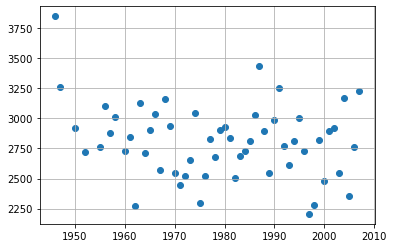

In [19]:
axes = plt.axes()
axes.grid() 
plt.scatter(df1.index,df1.loc[:,df1.columns[1]])
plt.show()